# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colors import ListedColormap
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

# Load Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [3]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration.root'
# file_input_name = '../runs/calibration_8x8x8_e-_5MeV/calibration.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../build/event100.root'
# file_input_name = '../runs/calibration_2.42^3_10000gamma_1000events_20cmFOVL.root'
# file_input_name = '../build/1800MeV_mu_-1.21x3_1x3.root'
# file_input_name = '../build/calibration.root'
# file_input_name = '../runs/calibration_2.42^3_10000gamma_1000events_0cmFOVL_+-0randPosNoSteps_randDir.root'
# file_input_name = '../runs/calibration_2.42^3_10000gamma_1000events_0cmFOVL_+-0.00randPosNoSteps_randDir.root'
# file_input_name = '../build/200MeV_mu_-1.21x3_1x3.root'
file_input_name = '../build/event_NEST_newLXe.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [4]:
hits_list_library = {}
hits_hist_library = {}
for name in tqdm.tqdm(histogram_names):
    # Get the histogram from the ROOT file
    histogram = file_input_pyroot.Get(name)

    # Get the number of bins in the X and Y directions
    n_bins_x = histogram.GetNbinsX() # // 10
    n_bins_y = histogram.GetNbinsY() # // 10

    # Create NumPy arrays to store the bin contents and edges
    values = np.zeros((n_bins_x, n_bins_y))
    hits = []
    x_edges = []
    y_edges = []

    # Extract the bin contents (values) and edges
    for i in range(1, n_bins_x + 2):
        x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
    for i in range(1, n_bins_y + 2):
        y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))

    for i in range(n_bins_x):  # Change the range to avoid going out of bounds
        for j in range(n_bins_y):  # Change the range to avoid going out of bounds
            values[i][j] = histogram.GetBinContent(j + 1, i + 1)
            if histogram.GetBinContent(j + 1, i + 1) > 0:
                # Check if edges are within bounds before accessing
                if j < len(y_edges) - 1 and i < len(x_edges) - 1:
                    hits.append(
                        (y_edges[j] + (y_edges[j + 1] - y_edges[j]) / 2, x_edges[i] + (x_edges[i + 1] - x_edges[i]) / 2)
                    )

    # print(name,hits)
    hits_list_library[name] = hits
    hits_hist_library[name] = values

100%|██████████| 1350/1350 [00:05<00:00, 242.56it/s]


# Visuliaze Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/1617523827.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


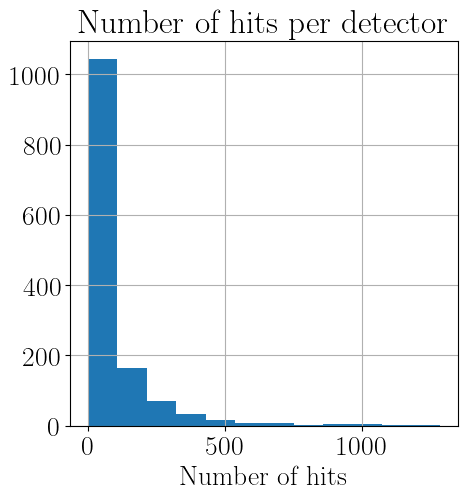

In [5]:
# Find the entry in hits_library with the largest length
# make a list of the index and length
lengths = [(i, len(hits)) for i, hits in enumerate(hits_list_library.values())]
lengths.sort(key=lambda x: x[1])

fig, ax = plt.subplots()
ax.hist([lengths[i][1] for i in range(len(lengths))], bins=12)
ax.set_xlabel("Number of hits")
ax.set_ylabel("")
ax.set_title("Number of hits per detector")
ax.grid()
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/2060655599.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


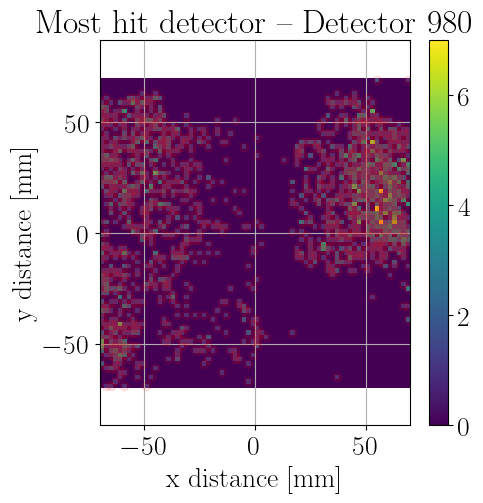

In [6]:
index, length = lengths[-1]
hits = list(hits_list_library.values())[index]
values = list(hits_hist_library.values())[index]

fig, ax = plt.subplots()
im = ax.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), aspect='auto', origin='lower', cmap='viridis')
ax.plot([x[0] for x in hits], [x[1] for x in hits], 'o', alpha=0.1, color='red')
fig.colorbar(im, ax=ax)
ax.set_xlabel("x distance [mm]")
ax.set_ylabel("y distance [mm]")
ax.set_title("Most hit detector -- Detector " + str(index))
ax.grid()
ax.axis('equal')
fig.show()

In [7]:
rainbow = cm.rainbow(np.linspace(0, 1, 10))
rainbow = np.insert(rainbow, 0, [0, 0, 0, 1], axis=0)
rainbow_cmap = ListedColormap(rainbow)

In [8]:
treeName_photoSensor = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensorName', 'sensorPosition', 'absolutePosition', 'relativePosition', 'sensorWall'])
df_hits['sensorName'      ] = get_photosensor_hits_photosensor_ID      (file_input_name, treeName_photoSensor)
df_hits['sensorPosition'  ] = get_photosensor_hits_photosensor_position(file_input_name, treeName_photoSensor)
df_hits['absolutePosition'] = get_photosensor_hits_position_absolute   (file_input_name, treeName_photoSensor)
df_hits['relativePosition'] = get_photosensor_hits_position_relative   (file_input_name, treeName_photoSensor)
df_hits['sensorWall'      ] = get_photosensor_hits_photosensor_wall    (file_input_name, treeName_photoSensor)

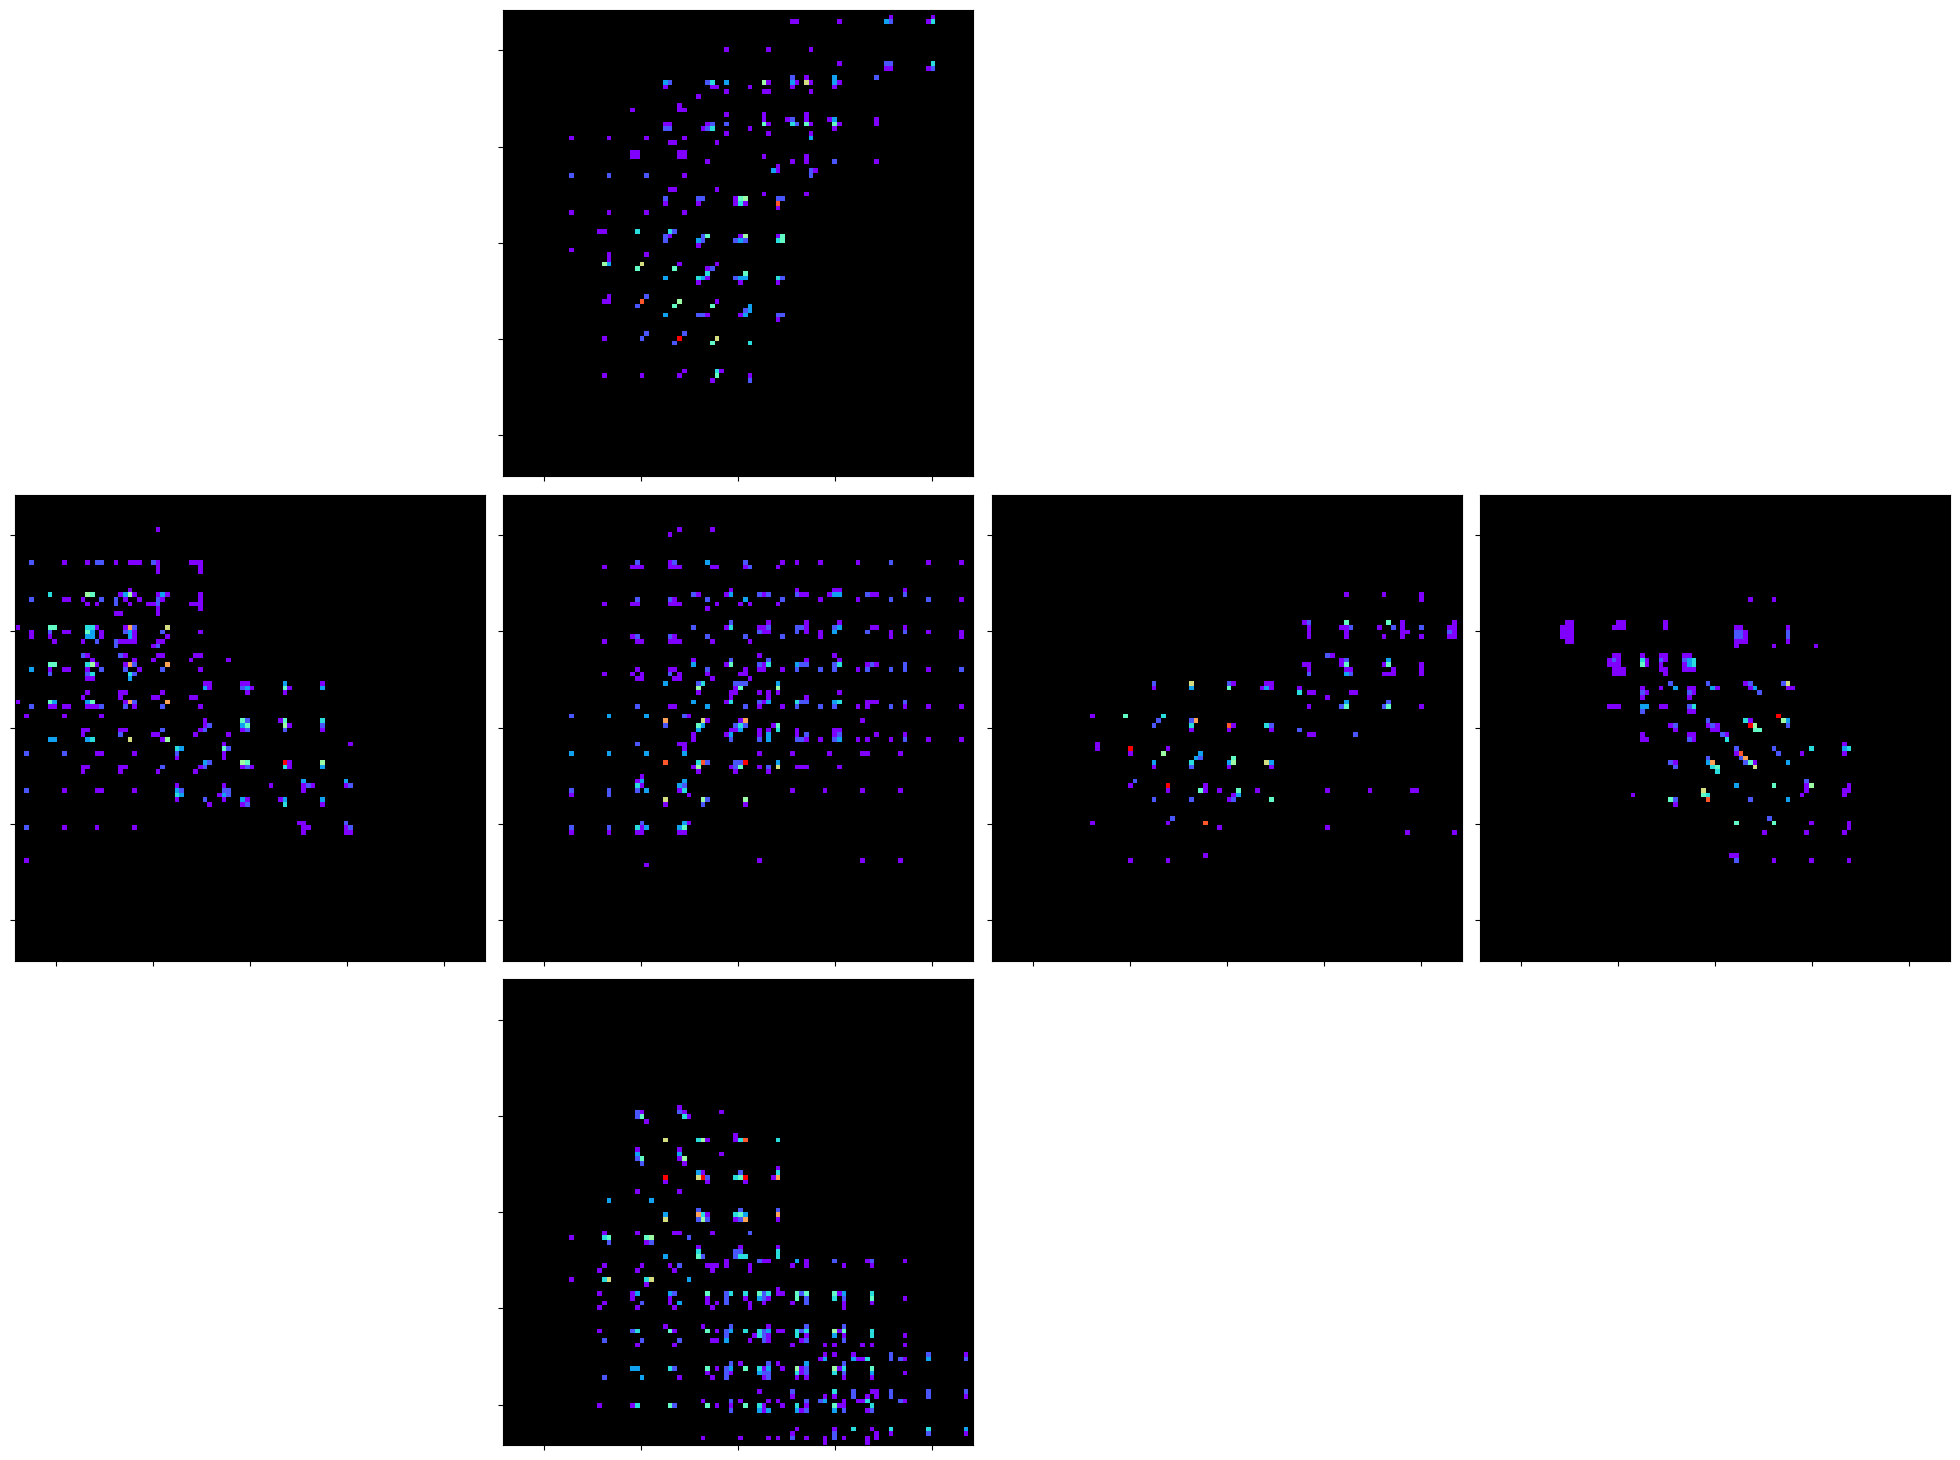

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

ax[0, 0].set_axis_off()
ax[0, 2].set_axis_off()
ax[0, 3].set_axis_off()
ax[2, 0].set_axis_off()
ax[2, 2].set_axis_off()
ax[2, 3].set_axis_off()

size = (1.21*1000, 1.21*1000)
nBins = 100

ax[0, 1].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+y'].apply(lambda x: x[0]), 
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+y'].apply(lambda x: x[2]),
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)
ax[1, 0].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-x'].apply(lambda x: -x[2]),
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-x'].apply(lambda x:  x[1]),
    bins=nBins, range=[[-size[1], size[1]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)
ax[1, 1].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-z'].apply(lambda x: x[0]),
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-z'].apply(lambda x: x[1]),
    bins=nBins, range=[[-size[0], size[0]], [-size[0], size[0]]], cmap=rainbow_cmap, norm=None
)
ax[1, 2].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+x'].apply(lambda x: x[2]),
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+x'].apply(lambda x: x[1]),
    bins=nBins, range=[[-size[1], size[1]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)
ax[1, 3].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+z'].apply(lambda x: -x[0]),
    df_hits['absolutePosition'][df_hits['sensorWall'] == '+z'].apply(lambda x:  x[1]),
    bins=nBins, range=[[-size[0], size[0]], [-size[0], size[0]]], cmap=rainbow_cmap, norm=None
)
ax[2, 1].hist2d(
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-y'].apply(lambda x:  x[0]),
    df_hits['absolutePosition'][df_hits['sensorWall'] == '-y'].apply(lambda x: -x[2]),
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)

ax[0, 1].set_xlim(-size[0], size[0])
ax[0, 1].set_ylim(-size[1], size[1])
ax[1, 0].set_xlim(-size[1], size[1])
ax[1, 0].set_ylim(-size[1], size[1])
ax[1, 1].set_xlim(-size[0], size[0])
ax[1, 1].set_ylim(-size[0], size[0])
ax[1, 2].set_xlim(-size[1], size[1])
ax[1, 2].set_ylim(-size[1], size[1])
ax[1, 3].set_xlim(-size[0], size[0])
ax[1, 3].set_ylim(-size[0], size[0])
ax[2, 1].set_xlim(-size[0], size[0])
ax[2, 1].set_ylim(-size[1], size[1])

ax[0, 1].set_xticklabels([])
ax[0, 1].set_yticklabels([])
ax[1, 0].set_xticklabels([])
ax[1, 0].set_yticklabels([])
ax[1, 1].set_xticklabels([])
ax[1, 1].set_yticklabels([])
ax[1, 2].set_xticklabels([])
ax[1, 2].set_yticklabels([])
ax[1, 3].set_xticklabels([])
ax[1, 3].set_yticklabels([])
ax[2, 1].set_xticklabels([])
ax[2, 1].set_yticklabels([])

fig.tight_layout(h_pad=0.5, w_pad=0.5)

# plt.savefig('../figures/absolutePosition_eventDisplay.pdf', format='pdf', bbox_inches='tight')
plt.show()

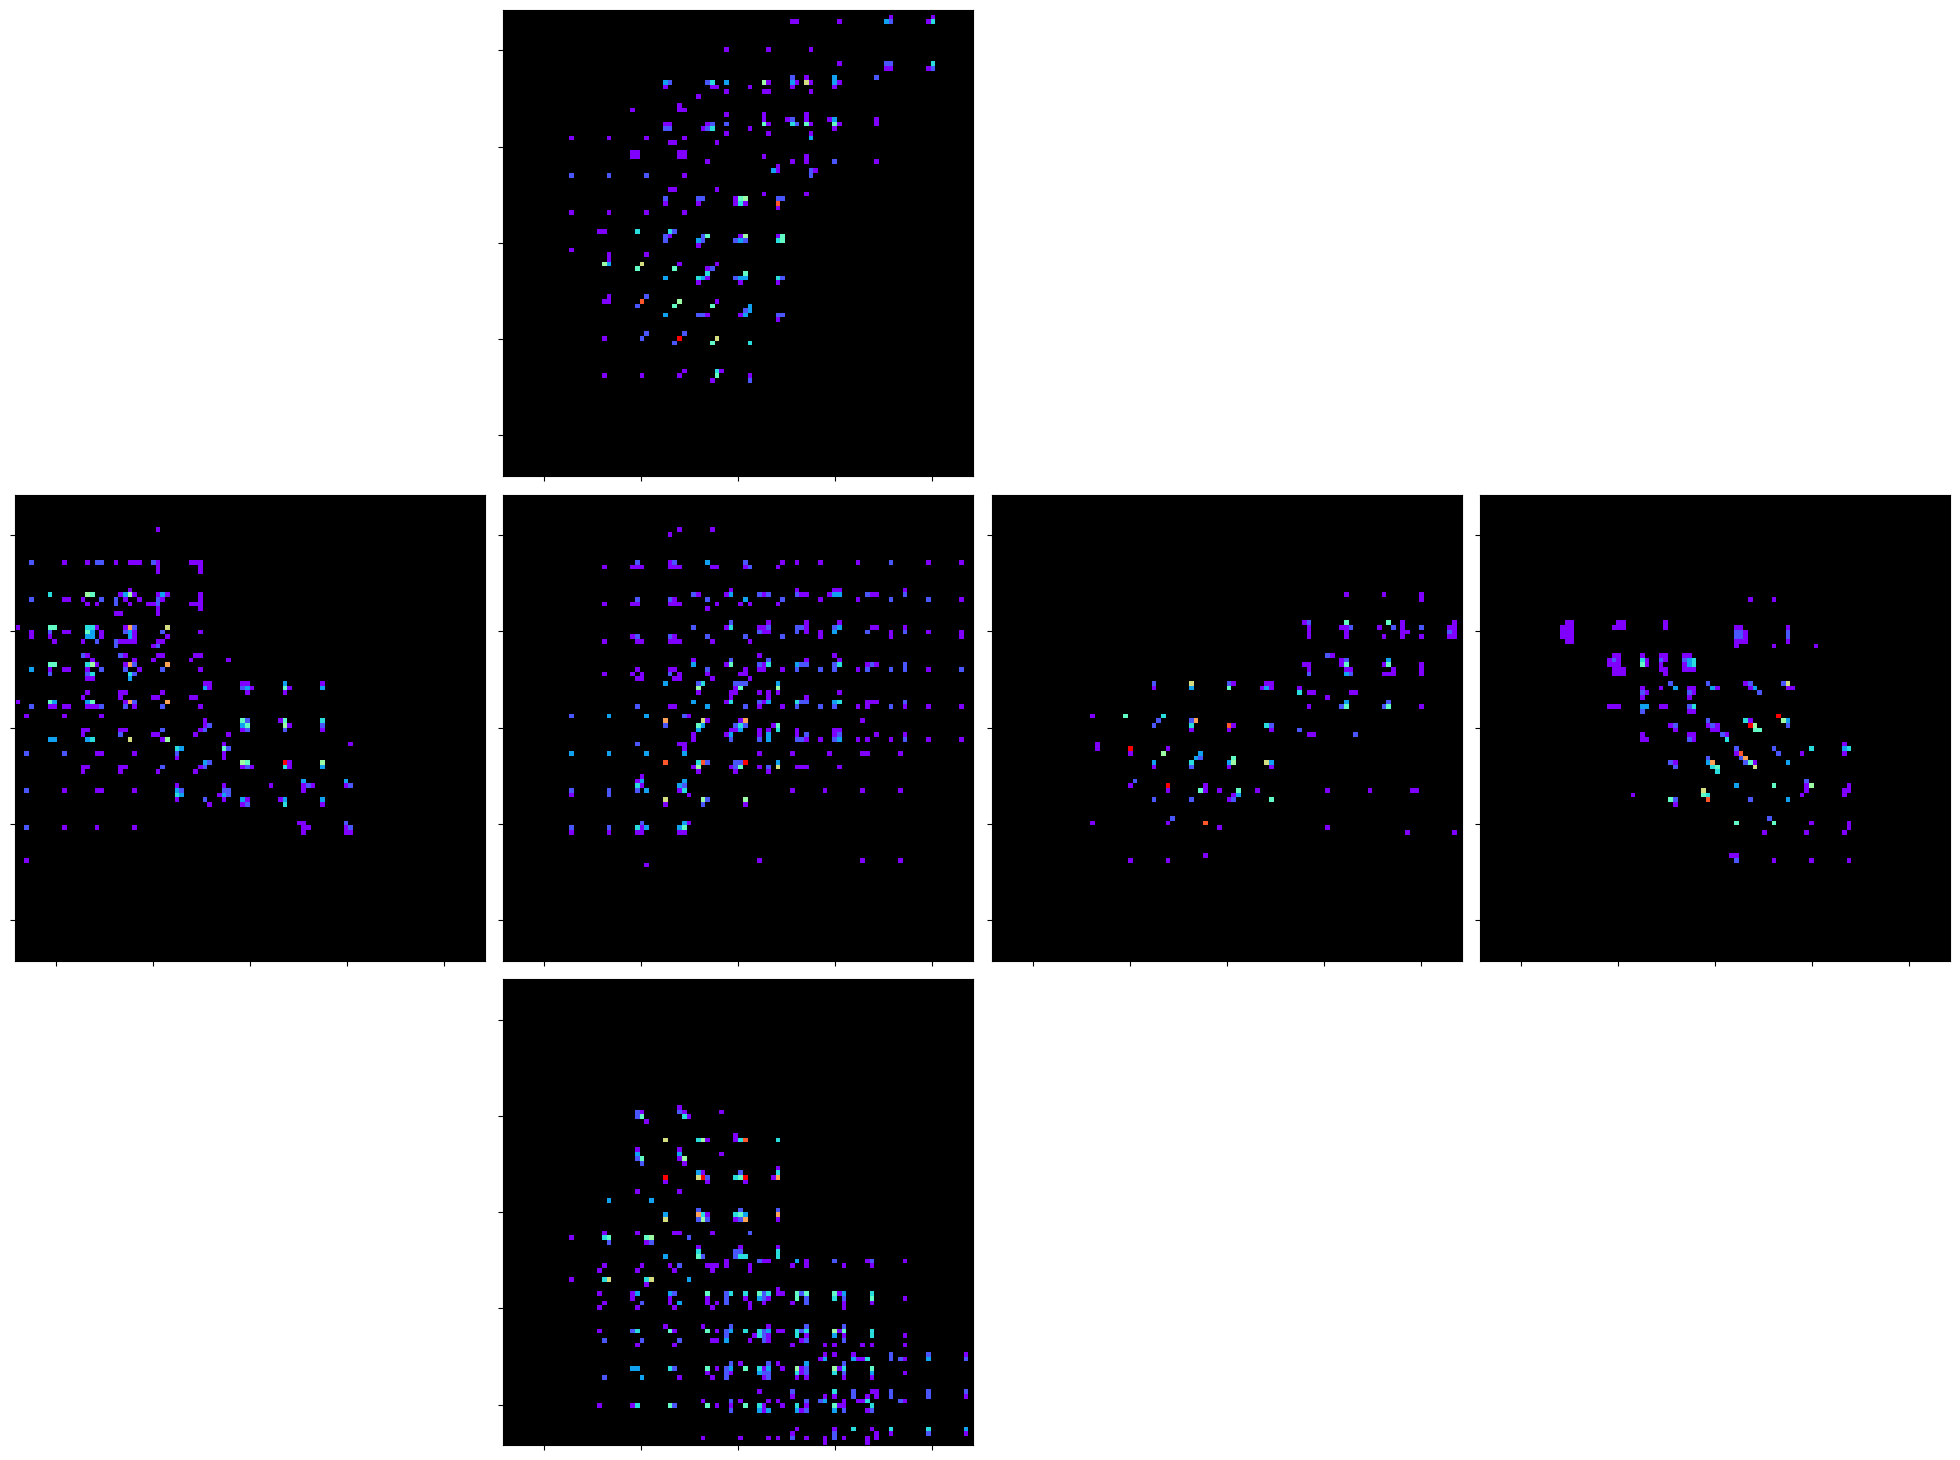

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

ax[0, 0].set_axis_off()
ax[0, 2].set_axis_off()
ax[0, 3].set_axis_off()
ax[2, 0].set_axis_off()
ax[2, 2].set_axis_off()
ax[2, 3].set_axis_off()

size = (1.21*1000, 1.21*1000)
nBins = 100

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+y'].apply(lambda x: -x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+y'].apply(lambda x:  x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+y'].apply(lambda x:  x[0]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+y'].apply(lambda x:  x[2]))
x0 = r0 + a0
x1 = r1 + a1
ax[0, 1].hist2d(
    x0, 
    x1,
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-x'].apply(lambda x:  x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-x'].apply(lambda x: -x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-x'].apply(lambda x: -x[2]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-x'].apply(lambda x:  x[1]))
x0 = r0 + a0
x1 = r1 + a1
ax[1, 0].hist2d(
    x0,
    x1,
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-z'].apply(lambda x: -x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-z'].apply(lambda x: -x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-z'].apply(lambda x:  x[0]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-z'].apply(lambda x:  x[1]))
x0 = r0 + a0
x1 = r1 + a1
ax[1, 1].hist2d(
    x0,
    x1,
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+x'].apply(lambda x:  x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+x'].apply(lambda x: -x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+x'].apply(lambda x:  x[2]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+x'].apply(lambda x:  x[1]))
x0 = r0 + a0
x1 = r1 + a1
ax[1, 2].hist2d(
    x0,
    x1,
    bins=nBins, range=[[-size[1], size[1]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+z'].apply(lambda x: -x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '+z'].apply(lambda x:  x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+z'].apply(lambda x: -x[0]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '+z'].apply(lambda x:  x[1]))
x0 = r0 + a0
x1 = r1 + a1
ax[1, 3].hist2d(
    x0,
    x1,
    bins=nBins, range=[[-size[0], size[0]], [-size[0], size[0]]], cmap=rainbow_cmap, norm=None
)

r0 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-y'].apply(lambda x: -x[0]))
r1 = np.array(df_hits['relativePosition'][df_hits['sensorWall'] == '-y'].apply(lambda x:  x[1]))
a0 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-y'].apply(lambda x:  x[0]))
a1 = np.array(df_hits['sensorPosition'  ][df_hits['sensorWall'] == '-y'].apply(lambda x: -x[2]))
x0 = r0 + a0
x1 = r1 + a1
ax[2, 1].hist2d(
    x0,
    x1,
    bins=nBins, range=[[-size[0], size[0]], [-size[1], size[1]]], cmap=rainbow_cmap, norm=None
)


ax[0, 1].set_xlim(-size[0], size[0])
ax[0, 1].set_ylim(-size[1], size[1])
ax[1, 0].set_xlim(-size[1], size[1])
ax[1, 0].set_ylim(-size[1], size[1])
ax[1, 1].set_xlim(-size[0], size[0])
ax[1, 1].set_ylim(-size[0], size[0])
ax[1, 2].set_xlim(-size[1], size[1])
ax[1, 2].set_ylim(-size[1], size[1])
ax[1, 3].set_xlim(-size[0], size[0])
ax[1, 3].set_ylim(-size[0], size[0])
ax[2, 1].set_xlim(-size[0], size[0])
ax[2, 1].set_ylim(-size[1], size[1])

ax[0, 1].set_xticklabels([])
ax[0, 1].set_yticklabels([])
ax[1, 0].set_xticklabels([])
ax[1, 0].set_yticklabels([])
ax[1, 1].set_xticklabels([])
ax[1, 1].set_yticklabels([])
ax[1, 2].set_xticklabels([])
ax[1, 2].set_yticklabels([])
ax[1, 3].set_xticklabels([])
ax[1, 3].set_yticklabels([])
ax[2, 1].set_xticklabels([])
ax[2, 1].set_yticklabels([])

fig.tight_layout(h_pad=0.5, w_pad=0.5)

# plt.savefig('../figures/relativePosition_eventDisplay.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [11]:
def plot_DSPSs(histograms, fig=None, axes=None, xdim=15, ydim=15, cmap=rainbow_cmap, norm=None):
    if fig is None or axes is None:
        fig, axes = plt.subplots(nrows=ydim, ncols=xdim, figsize=(10, 10))
        axes = np.flip(axes, axis=0)
    for (i, ax), (values, position) in tqdm.tqdm(zip(enumerate(axes.flat), histograms)):
        ax.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), origin='lower', cmap=rainbow_cmap, norm=norm)
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.set_title("{:.1f}, {:.1f}, {:.1f}".format(position[0], position[1], position[2]), fontsize=5)
        ax.set_title("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.grid()
    fig.tight_layout(h_pad=0, w_pad=0)
    return fig, axes

[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
Z value = -1184.70422
[(1125, (-1120.0, -1120.0, -1184.70422)), (1126, (-1120.0, -960.0, -1184.70422)), (1127, (-1120.0, -800.0, -1184.70422)), (1128, (-1120.0, -640.0, -1184.70422)), (1129, (-1120.0, -480.0, -1184.70422)), (1130, (-1120.0, -320.0, -1184.70422)), (1131, (-1120.0, -160.0, -1184.70422)), (1132, (-1120.0, 0.0, -1184.70422)), (1133, (-1120.0, 160.0, -1184.70422)), (1134, (-1120.0, 320.0, -1184.70422)), (1135, (-1120.0, 480.0, -1184.70422)), (1136, (-1120.0, 640.0, -1184.70422)), (1137, (-1120.0, 800.0, -1184.70422)), (1138, (-1120.0, 960.0, -1184.70422)), (1139, (-1120.0, 1120.0, -1184.70422)), (1140, (-960.0, -1120.0, -1184.70422)), (1141, (-960.0, -960.0, -1184.70422)), (1142, (-960.0, -800.0, -1184.70422)), (1143, (-960.0, -640.0, -1184.70422)), (1144, (-960.0, -480.0, -1184.

225it [00:00, 2788.45it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3903898399.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_nz.show()


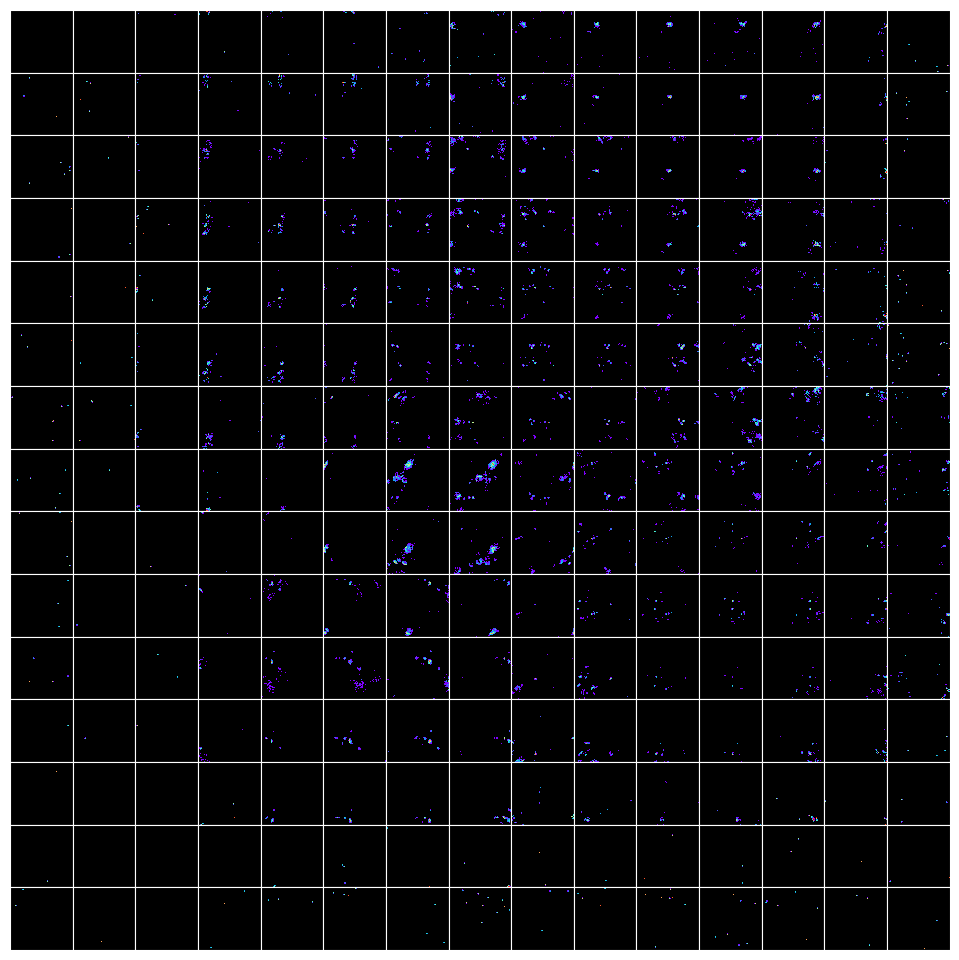

In [12]:
#####################################################################################################
################################               +z                    ################################
#####################################################################################################

histograms_nz = []
print(np.unique(np.array(histogram_positions)[:, 2]))
z_value = np.unique(np.array(histogram_positions)[:, 2])[0]
print('Z value =', z_value)
for i, position in enumerate(histogram_positions):
    if position[2] == z_value:
        histograms_nz.append((i, position))

print(histograms_nz)

histograms_nz.sort(key=lambda hist: (hist[1][ABSOLUTE_SENSOR_POSITIONS_XY_INDEX['-z'][0]]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-z'][0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-z'][0],
                                     hist[1][ABSOLUTE_SENSOR_POSITIONS_XY_INDEX['-z'][1]]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-z'][1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-z'][1]))
histograms_nz.sort(key=lambda hist: (hist[1][0], hist[1][1]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_nz]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-z'][0],
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-z'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape).T)
histograms_nz = [(values_rotated[i], position) for i, position in enumerate(histograms_nz)]

fig_nz_name = '../figures/preliminaryAnalysis_eventDisplay_-z.pdf'
fig_nz, axes_nz = plot_DSPSs(histograms_nz)
fig_nz.savefig(fig_nz_name, bbox_inches='tight')
fig_nz.show()


[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
Z value = 1184.70422


225it [00:00, 868.56it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/1394586088.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_pz.show()


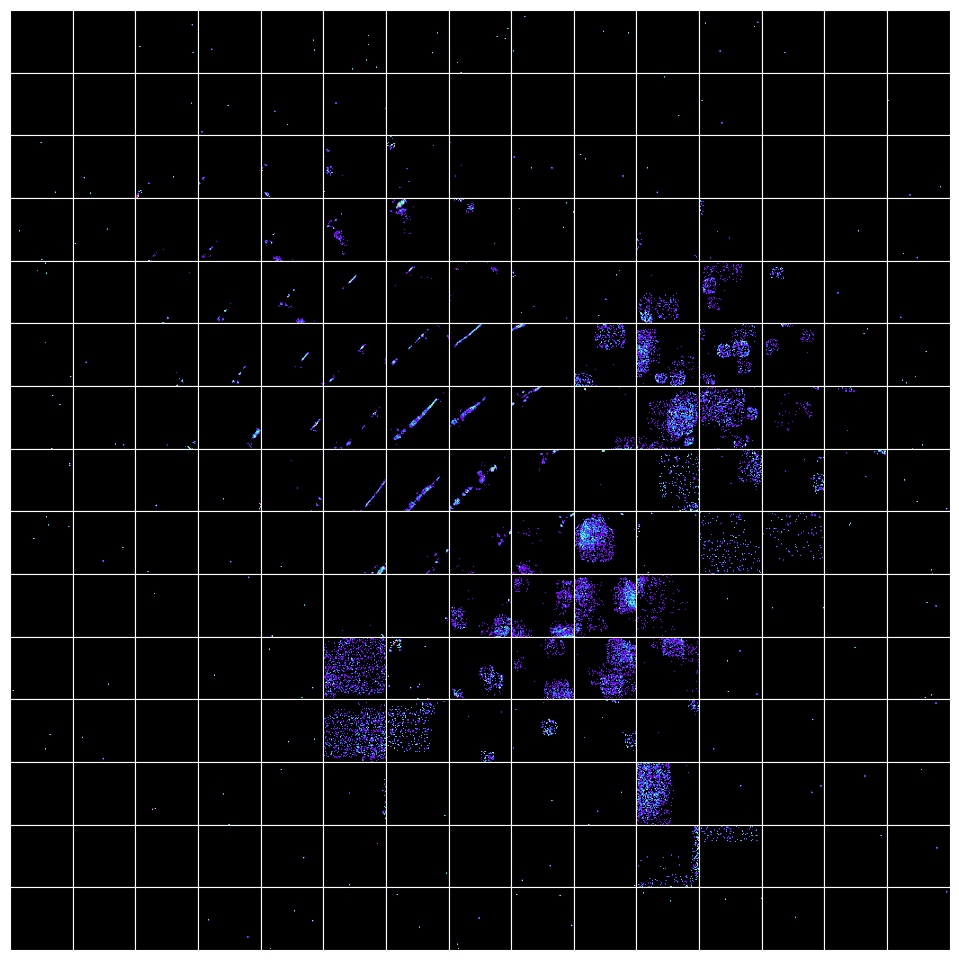

In [13]:
#####################################################################################################
################################               +z                    ################################
#####################################################################################################

histograms_pz = []
print(np.unique(np.array(histogram_positions)[:, 2]))
z_value = np.unique(np.array(histogram_positions)[:, 2])[-1]
print('Z value =', z_value)
for i, position in enumerate(histogram_positions):
    if position[2] == z_value:
        histograms_pz.append((i, position))

histograms_pz.sort(key=lambda hist: (hist[1][ABSOLUTE_SENSOR_POSITIONS_XY_INDEX['+z'][0]]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+z'][0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+z'][0],
                                     hist[1][ABSOLUTE_SENSOR_POSITIONS_XY_INDEX['+z'][1]]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+z'][1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+z'][1]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_pz]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+z'][0], 
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+z'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape))
histograms_pz = [(values_rotated[i], position) for i, position in enumerate(histograms_pz)]

fig_pz_name = '../figures/preliminaryAnalysis_eventDisplay_+z.pdf'
fig_pz, axes_pz = plot_DSPSs(histograms_pz)
fig_pz.savefig(fig_pz_name, bbox_inches='tight')
fig_pz.show()

[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
Y value = -1184.70422


225it [00:00, 2817.04it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3019137039.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_ny.show()


[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
Y value = 1184.70422


225it [00:00, 3010.35it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3019137039.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_py.show()


[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
X value = -1184.70422


225it [00:00, 2988.12it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3019137039.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_nx.show()


[-1184.70422 -1120.       -960.       -800.       -640.       -480.
  -320.       -160.          0.        160.        320.        480.
   640.        800.        960.       1120.       1184.70422]
X value = 1184.70422


225it [00:00, 3083.54it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3019137039.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_px.show()


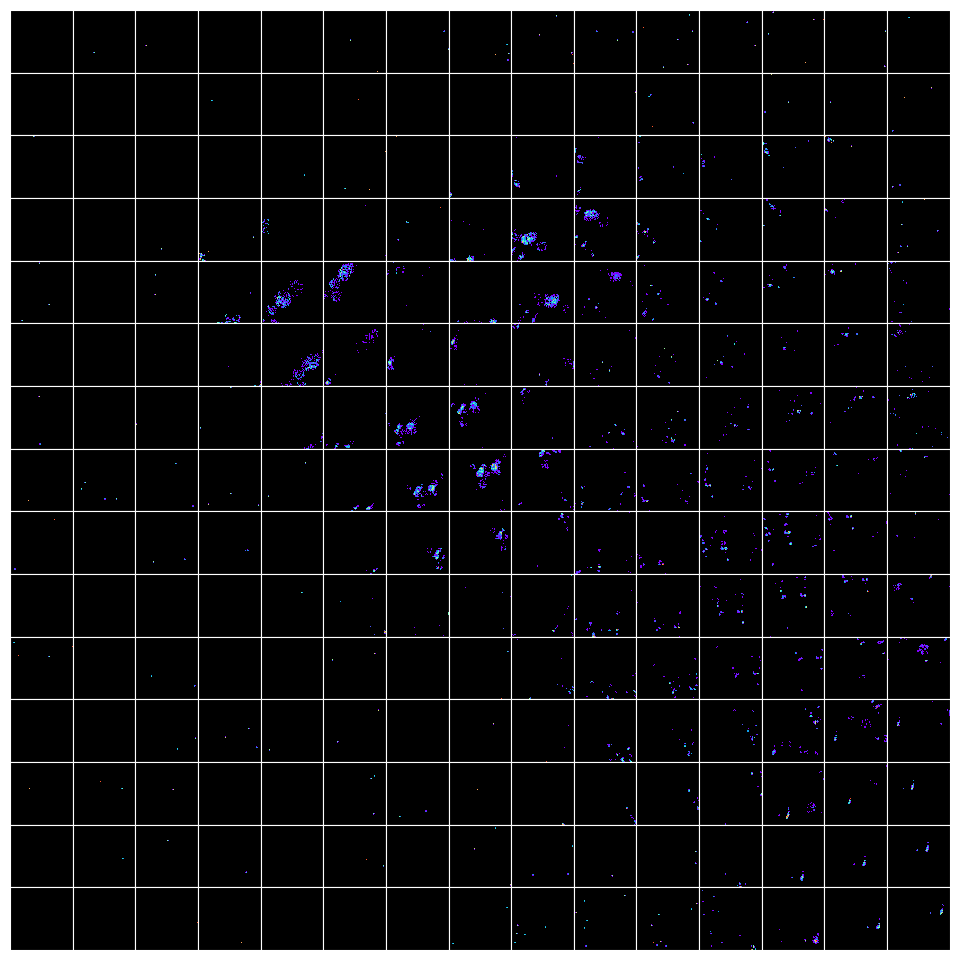

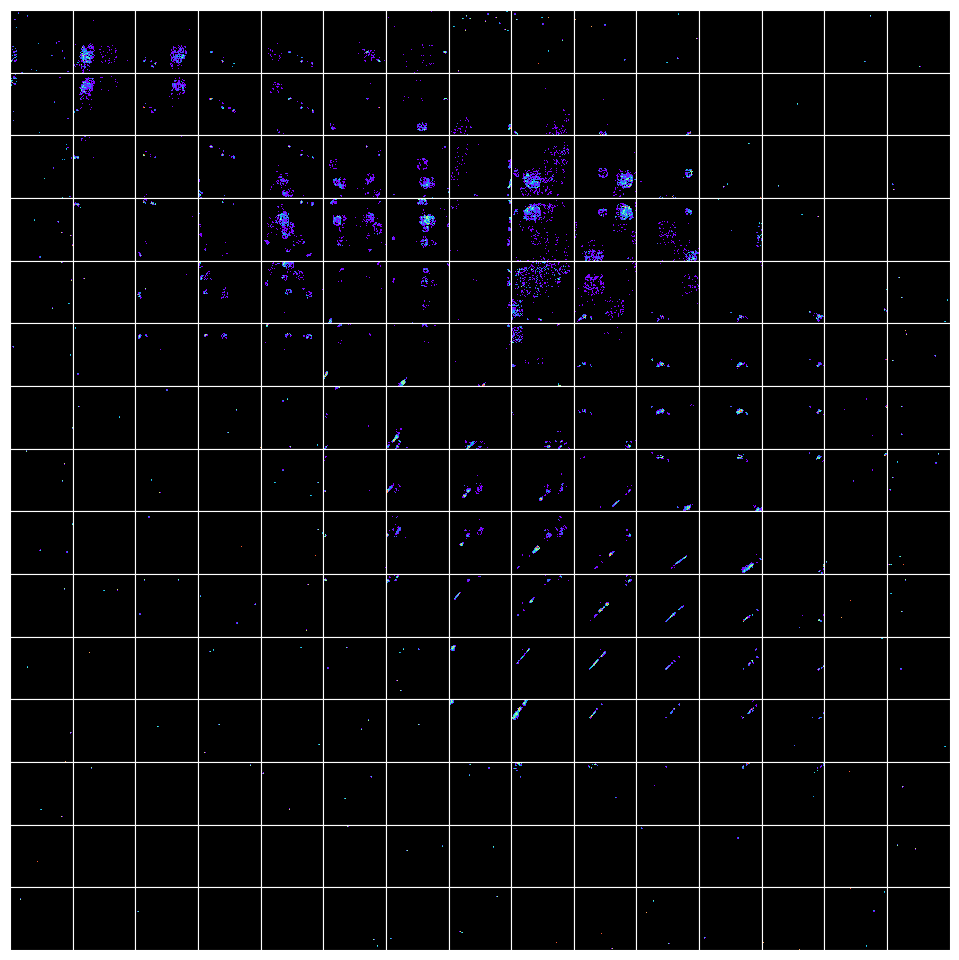

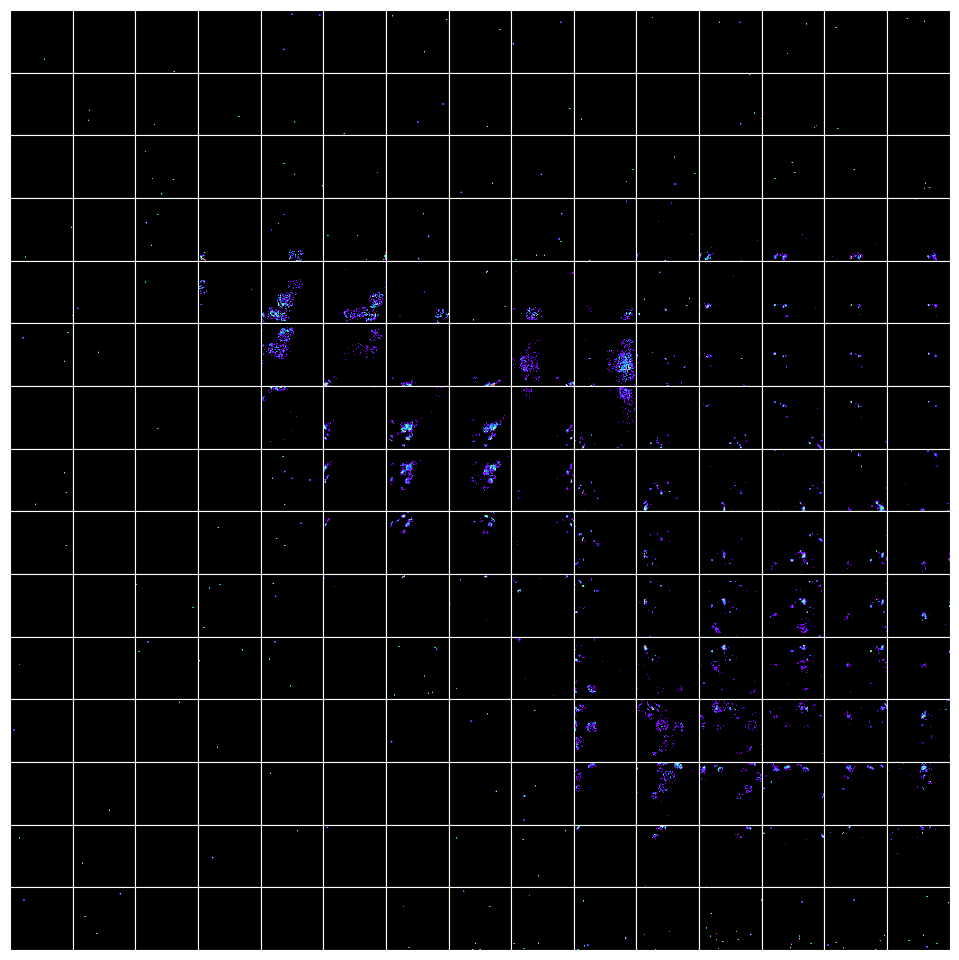

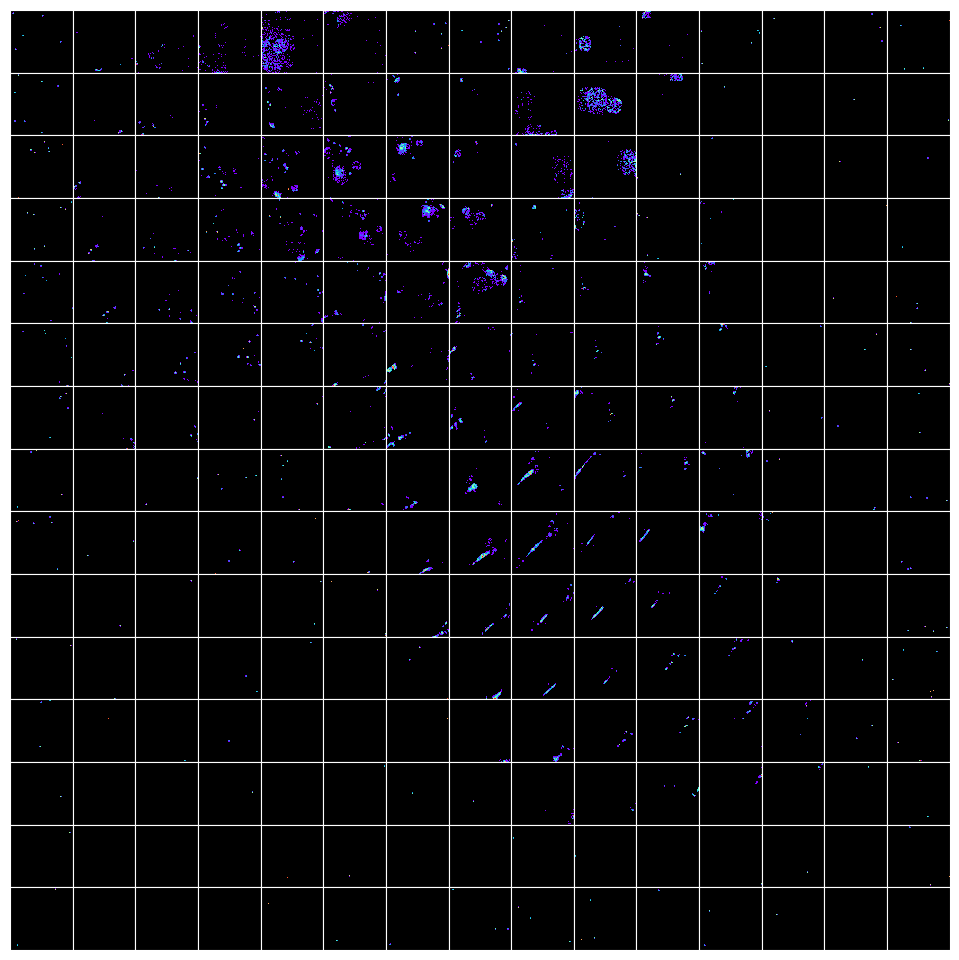

In [14]:

#####################################################################################################
################################               -y                    ################################
#####################################################################################################

histograms_ny = []
print(np.unique(np.array(histogram_positions)[:, 1]))
y_value = np.unique(np.array(histogram_positions)[:, 1])[0]
print('Y value =', y_value)
for i, position in enumerate(histogram_positions):
    if position[1] == y_value:
        histograms_ny.append((i, position))

histograms_ny.sort(key=lambda hist: (hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['-y'][0]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-y'][0]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-y'][0],
                                     hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['-y'][1]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-y'][1]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-y'][1]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_ny]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-y'][0], 
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-y'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape))
histograms_ny = [(values_rotated[i], position) for i, position in enumerate(histograms_ny)]

fig_ny_name = '../figures/preliminaryAnalysis_eventDisplay_-y.pdf'
fig_ny, axes_ny = plot_DSPSs(histograms_ny)
fig_ny.savefig(fig_ny_name, bbox_inches='tight')
fig_ny.show()

#####################################################################################################
################################               +y                    ################################
#####################################################################################################

histograms_py = []
print(np.unique(np.array(histogram_positions)[:, 1]))
y_value = np.unique(np.array(histogram_positions)[:, 1])[-1]
print('Y value =', y_value)
for i, position in enumerate(histogram_positions):
    if position[1] == y_value:
        histograms_py.append((i, position))

histograms_py.sort(key=lambda hist: (hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['+y'][1]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+y'][1]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+y'][1],
                                     hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['+y'][0]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+y'][0]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+y'][0]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_py]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+y'][0]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+y'][0],
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+y'][1]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+y'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape))
histograms_py = [(values_rotated[i], position) for i, position in enumerate(histograms_py)]

fig_py_name = '../figures/preliminaryAnalysis_eventDisplay_+y.pdf'
fig_py, axes_py = plot_DSPSs(histograms_py)
fig_py.savefig(fig_py_name, bbox_inches='tight')
fig_py.show()

#####################################################################################################
################################               -x                    ################################
#####################################################################################################

histograms_nx = []
print(np.unique(np.array(histogram_positions)[:, 1]))
x_value = np.unique(np.array(histogram_positions)[:, 0])[0]
print('X value =', x_value)
for i, position in enumerate(histogram_positions):
    if position[0] == x_value:
        histograms_nx.append((i, position))

histograms_nx.sort(key=lambda hist: (hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['-x'][1]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-x'][1]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-x'][1],
                                     hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['-x'][0]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-x'][0]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['-x'][0]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_nx]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-x'][0], 
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['-x'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape))
histograms_nx = [(values_rotated[i], position) for i, position in enumerate(histograms_nx)]

fig_nx_file = '../figures/preliminaryAnalysis_eventDisplay_-x.pdf'
fig_nx, axes_nx = plot_DSPSs(histograms_nx)
fig_nx.savefig(fig_nx_file, bbox_inches='tight')
fig_nx.show()

#####################################################################################################
################################               +x                    ################################
#####################################################################################################

histograms_px = []
print(np.unique(np.array(histogram_positions)[:, 1]))
x_value = np.unique(np.array(histogram_positions)[:, 0])[-1]
print('X value =', x_value)
for i, position in enumerate(histogram_positions):
    if position[0] == x_value:
        histograms_px.append((i, position))

histograms_px.sort(key=lambda hist: (hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['+x'][0]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+x'][0]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+x'][0],
                                     hist[1][RELATIVE_SENSOR_POSITIONS_XYZ_INDEX['+x'][1]]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+x'][1]*ABSOLUTE_SENSOR_POSITIONS_XY_SIGN['+x'][1]))
values = [list(hits_hist_library.values())[i] for i, position in histograms_px]
values_rotated = []
for value in values:
    inds = [(i,j) for i in range(value.shape[0]) for j in range(value.shape[1])]
    inds.sort(key=lambda x: (x[0]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+x'][0], 
                             x[1]*RELATIVE_SENSOR_POSITIONS_XYZ_SIGN['+x'][1]))
    values_rotated.append(np.array([value[i, j] for i, j in inds]).reshape(value.shape))
histograms_px = [(values_rotated[i], position) for i, position in enumerate(histograms_px)]

fig_px_file = '../figures/preliminaryAnalysis_eventDisplay_+x.pdf'
fig_px, axes_px = plot_DSPSs(histograms_px)
fig_px.savefig(fig_px_file, bbox_inches='tight')
fig_px.show()

225it [00:00, 1817.45it/s]
225it [00:00, 2832.29it/s]
225it [00:00, 2873.63it/s]
225it [00:00, 3117.08it/s]
225it [00:00, 3084.56it/s]
225it [00:00, 3044.37it/s]


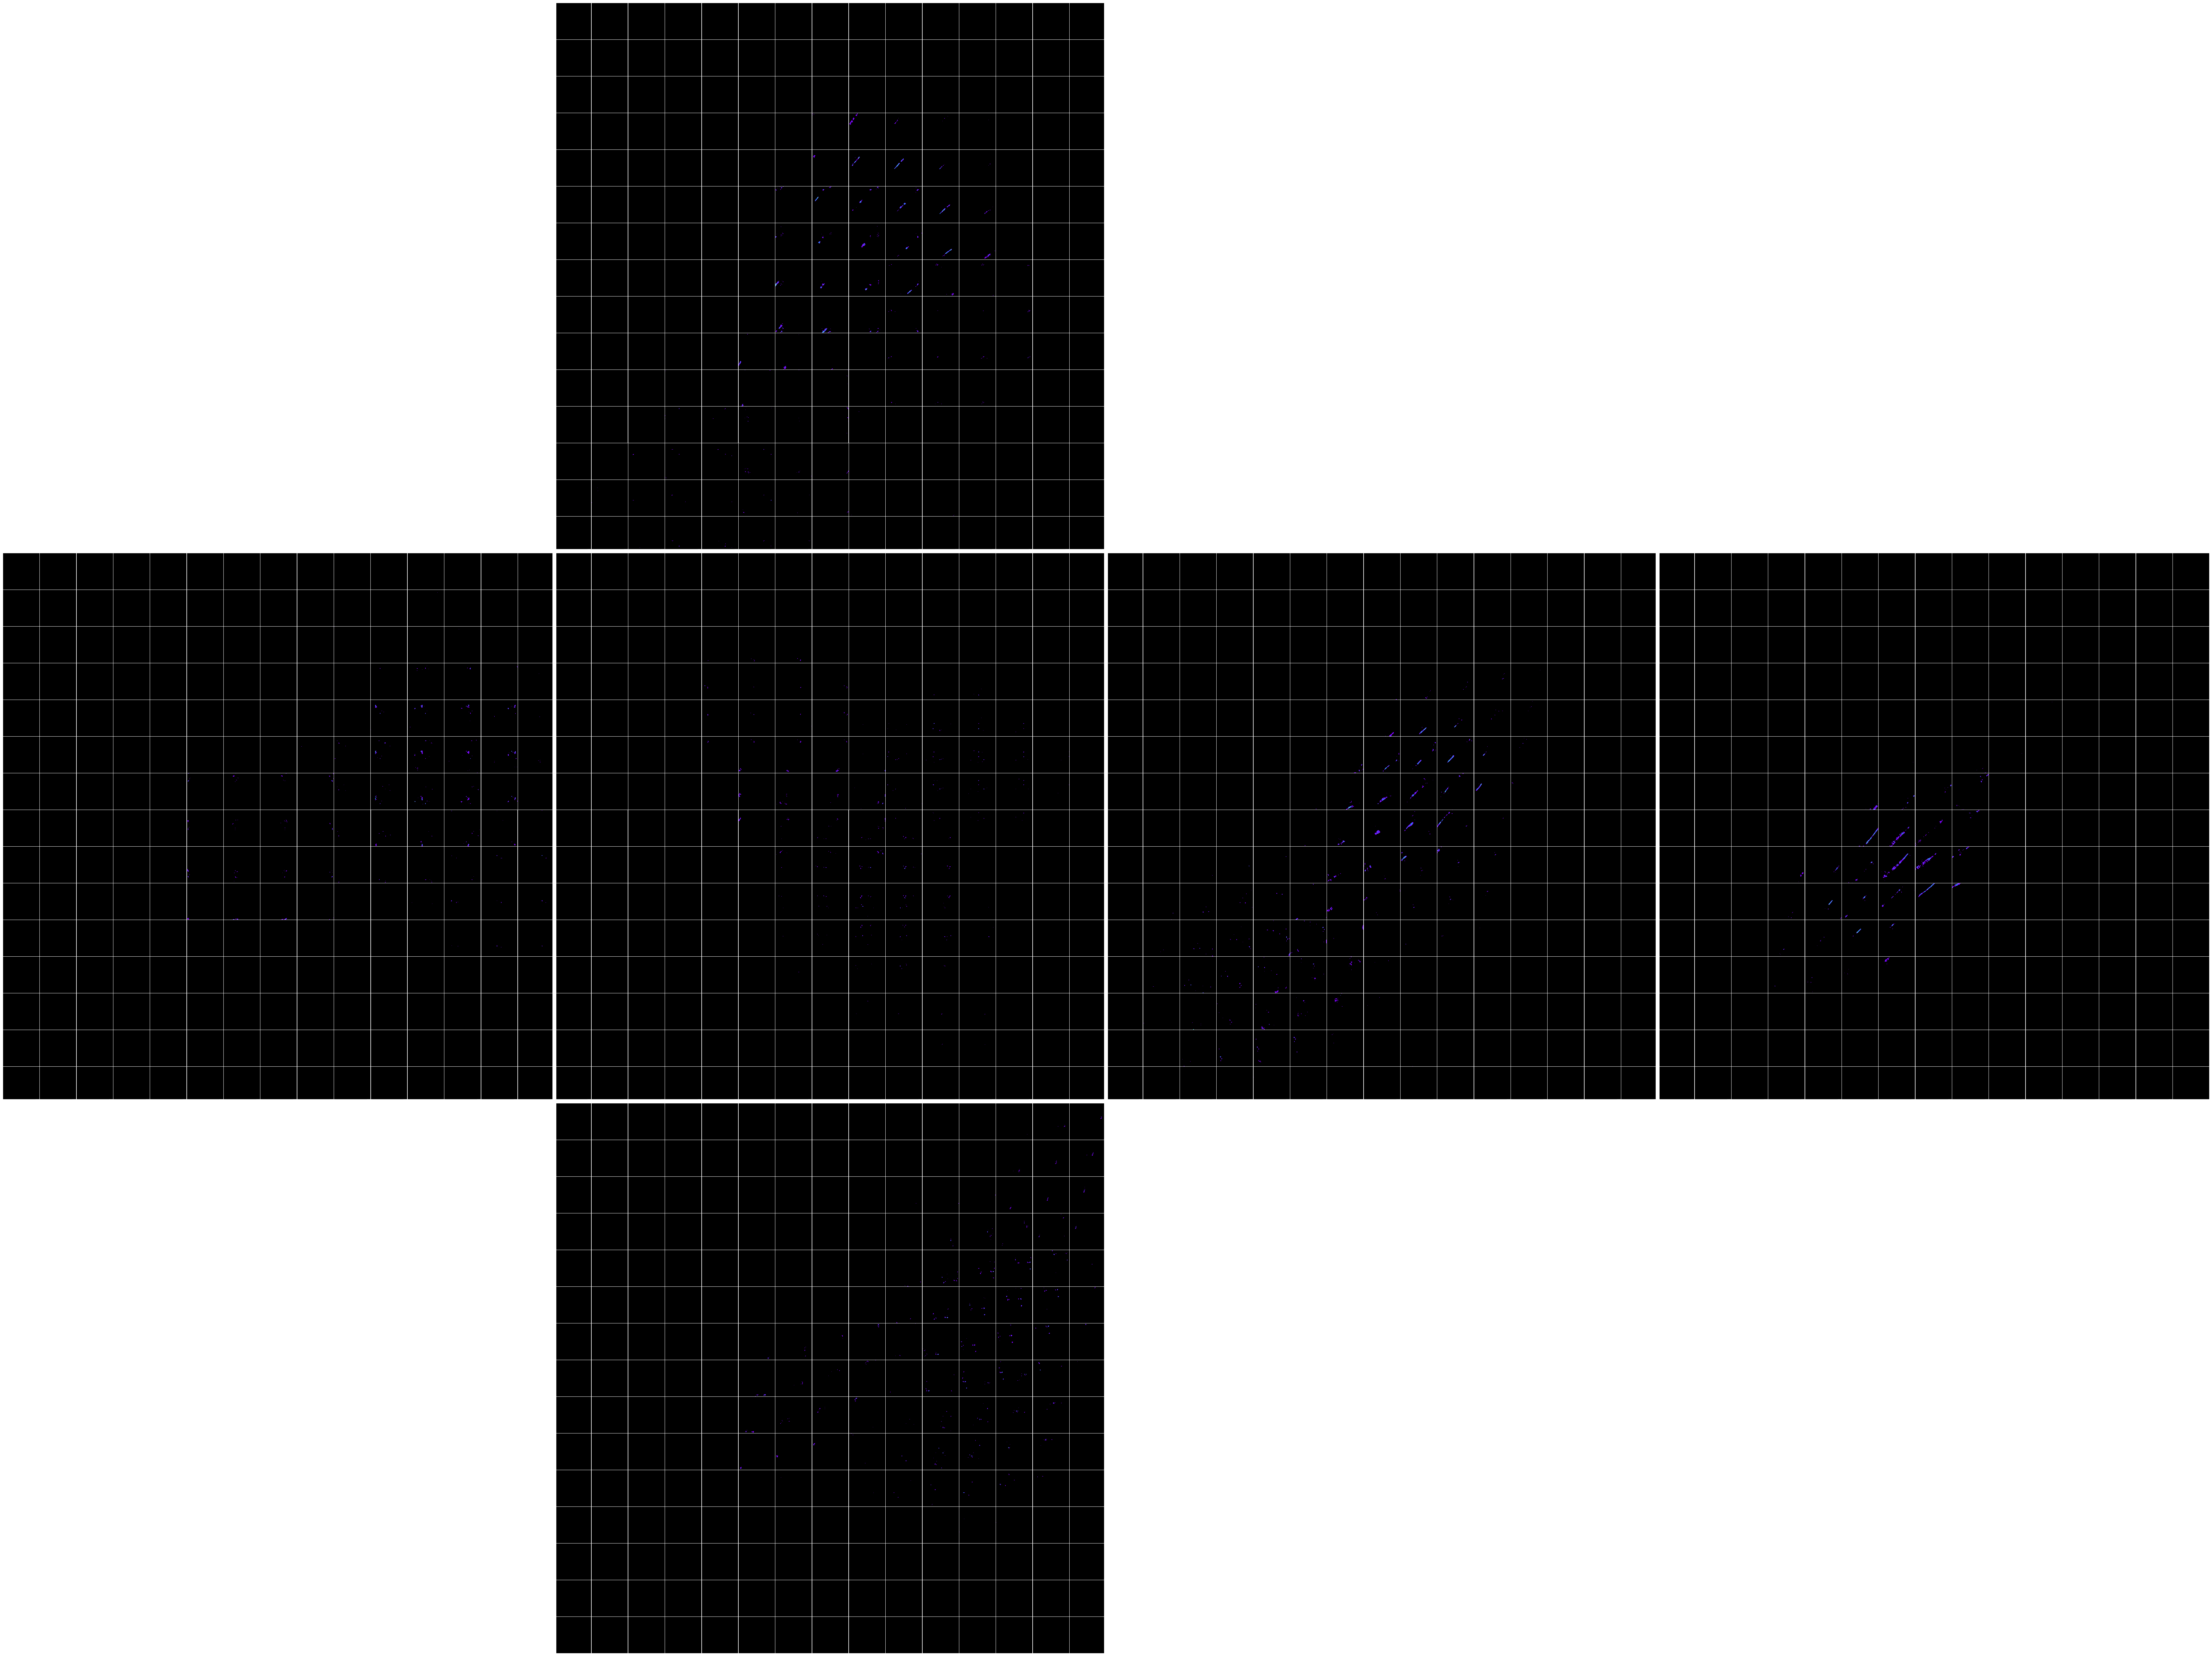

In [15]:
#####################################################################################################
################################              BOX                    ################################
#####################################################################################################

xdim = 15
ydim = 15

xsize = 20
ysize = 20

norm = mpl.colors.Normalize(
                   vmin=0, 
    vmax=np.max([
        np.max([np.max(histogram) for histogram, _ in histograms_nz]),
        np.max([np.max(histogram) for histogram, _ in histograms_pz]),
        np.max([np.max(histogram) for histogram, _ in histograms_nx]),
        np.max([np.max(histogram) for histogram, _ in histograms_px]),
        np.max([np.max(histogram) for histogram, _ in histograms_py]),
        np.max([np.max(histogram) for histogram, _ in histograms_ny]),
    ]))

fig, axes = plt.subplots(nrows=3*ydim, ncols=4*xdim, figsize=(xsize*4, ysize*3))

# cbar = fig.colorbar(im, ax=axes[xdim*2, 0], orientation='vertical', fraction=0.01, pad=0.01)
# cbar.ax.tick_params(labelsize=40)

for i, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title ("")
    ax.spines['bottom'].set_color('white')
    ax.spines['top'   ].set_color('white')
    ax.spines['right' ].set_color('white')
    ax.spines['left'  ].set_color('white')
    ax.grid()

# for xi, yi in [(0, 0), (0, 2), (0,3), (2, 0), (2, 2), (2, 3)]:
#     for xj in range(xdim):
#         for yj in range(ydim):
#             ax = axes[xi*xdim+xj, yi*ydim+yj]
#             ax.set_axis_off()

lw = 20
for ax in axes[:, xdim*1]:
    ax.spines['left'].set_linewidth(lw/2)
for ax in axes[:, xdim*2]:
    ax.spines['left'].set_linewidth(lw/2)
for ax in axes[:, xdim*3]:
    ax.spines['left'].set_linewidth(lw/2)
for ax in axes[ydim*1-1, :]:
    ax.spines['bottom'].set_linewidth(lw)
for ax in axes[ydim*2-1, :]:
    ax.spines['bottom'].set_linewidth(lw)

plot_DSPSs(histograms_py, fig, axes[xdim*0:xdim*1, ydim*1:ydim*2], xdim, ydim, rainbow_cmap, norm) # xi, yi = 0, 1
plot_DSPSs(histograms_nx, fig, axes[xdim*1:xdim*2, ydim*0:ydim*1], xdim, ydim, rainbow_cmap, norm) # xi, yi = 1, 0
plot_DSPSs(histograms_nz, fig, axes[xdim*1:xdim*2, ydim*1:ydim*2], xdim, ydim, rainbow_cmap, norm) # xi, yi = 1, 1
plot_DSPSs(histograms_px, fig, axes[xdim*1:xdim*2, ydim*2:ydim*3], xdim, ydim, rainbow_cmap, norm) # xi, yi = 1, 2
plot_DSPSs(histograms_pz, fig, axes[xdim*1:xdim*2, ydim*3:ydim*4], xdim, ydim, rainbow_cmap, norm) # xi, yi = 1, 3
plot_DSPSs(histograms_ny, fig, axes[xdim*2:xdim*3, ydim*1:ydim*2], xdim, ydim, rainbow_cmap, norm) # xi, yi = 2, 1

fig.tight_layout(h_pad=0, w_pad=0)
fig.savefig('../figures/preliminaryAnalysis_eventDisplay.pdf', bbox_inches='tight')
plt.show()

In [16]:
# Load the trees from the root file
tree_library = {}
tree_branch_library = {}
branch_data = {}
for name in tqdm.tqdm(tree_names):
    tree_library[name] = file_input_uproot[name]
    tree_branch_library[name] = tree_library[name].keys()
    print(name, tree_branch_library[name])
    for key in tqdm.tqdm(tree_branch_library[name], total=len(tree_branch_library[name])):
        branch_data[key] = tree_library[name][key].array()

  0%|          | 0/6 [00:00<?, ?it/s]

photoSensor_hits;1 ['photoSensor_hits_position_absolute_x', 'photoSensor_hits_position_absolute_y', 'photoSensor_hits_position_absolute_z', 'photoSensor_hits_position_relative_x', 'photoSensor_hits_position_relative_y', 'photoSensor_hits_position_relative_z', 'photoSensor_hits_position_relative_lens_0_x', 'photoSensor_hits_position_relative_lens_0_y', 'photoSensor_hits_position_relative_lens_0_z', 'photoSensor_hits_position_relative_lens_1_x', 'photoSensor_hits_position_relative_lens_1_y', 'photoSensor_hits_position_relative_lens_1_z', 'photoSensor_hits_position_initial_x', 'photoSensor_hits_position_initial_y', 'photoSensor_hits_position_initial_z', 'photoSensor_hits_momentum_x', 'photoSensor_hits_momentum_y', 'photoSensor_hits_momentum_z', 'photoSensor_hits_direction_x', 'photoSensor_hits_direction_y', 'photoSensor_hits_direction_z', 'photoSensor_hits_direction_relative_x', 'photoSensor_hits_direction_relative_y', 'photoSensor_hits_direction_relative_z', 'photoSensor_hits_direction_r

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

calorimeter_hits;1 ['calorimeter_hits_position_absolute_x', 'calorimeter_hits_position_absolute_y', 'calorimeter_hits_position_absolute_z', 'calorimeter_hits_position_relative_x', 'calorimeter_hits_position_relative_y', 'calorimeter_hits_position_relative_z', 'calorimeter_hits_position_initial_x', 'calorimeter_hits_position_initial_y', 'calorimeter_hits_position_initial_z', 'calorimeter_hits_momentum_x', 'calorimeter_hits_momentum_y', 'calorimeter_hits_momentum_z', 'calorimeter_hits_direction_x', 'calorimeter_hits_direction_y', 'calorimeter_hits_direction_z', 'calorimeter_hits_direction_relative_x', 'calorimeter_hits_direction_relative_y', 'calorimeter_hits_direction_relative_z', 'calorimeter_hits_time', 'calorimeter_hits_process', 'calorimeter_hits_calorimeterID', 'calorimeter_hits_energy']


 33%|███▎      | 2/6 [00:08<00:18,  4.70s/it]

lens_hits;1 ['lens_hits_position_absolute_x', 'lens_hits_position_absolute_y', 'lens_hits_position_absolute_z', 'lens_hits_position_relative_x', 'lens_hits_position_relative_y', 'lens_hits_position_relative_z', 'lens_hits_position_initial_x', 'lens_hits_position_initial_y', 'lens_hits_position_initial_z', 'lens_hits_momentum_x', 'lens_hits_momentum_y', 'lens_hits_momentum_z', 'lens_hits_direction_x', 'lens_hits_direction_y', 'lens_hits_direction_z', 'lens_hits_direction_relative_x', 'lens_hits_direction_relative_y', 'lens_hits_direction_relative_z', 'lens_hits_time', 'lens_hits_process', 'lens_hits_lensID', 'lens_hits_energy', 'lens_hits_transmittance']


 50%|█████     | 3/6 [00:16<00:19,  6.55s/it]

medium_hits;1 ['medium_hits_position_absolute_x', 'medium_hits_position_absolute_y', 'medium_hits_position_absolute_z', 'medium_hits_position_initial_x', 'medium_hits_position_initial_y', 'medium_hits_position_initial_z', 'medium_hits_momentum_x', 'medium_hits_momentum_y', 'medium_hits_momentum_z', 'medium_hits_energy', 'medium_hits_process', 'medium_hits_time', 'medium_hits_mediumID', 'medium_hits_transmittance']


 67%|██████▋   | 4/6 [00:24<00:14,  7.00s/it]

primary;1 ['primary_position_x', 'primary_position_y', 'primary_position_z', 'primary_momentum_x', 'primary_momentum_y', 'primary_momentum_z', 'primary_process', 'primary_time', 'primary_energy', 'primary_volume', 'primary_pdg']


100%|██████████| 11/11 [00:00<00:00, 2226.28it/s]


photon;1 ['photon_length', 'photon_process', 'photon_time', 'photon_position_x', 'photon_position_y', 'photon_position_z', 'photon_momentum_x', 'photon_momentum_y', 'photon_momentum_z', 'photon_energy', 'photon_volume', 'photon_stepNumber']


100%|██████████| 6/6 [00:40<00:00,  6.71s/it]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/3536451747.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


position [ 0] = ( -499.6947972796684 -499.6942793639324 -499.6952190540457 )
direction[ 0] = ( 0.0 0.0 0.0 )
position [-1] = ( 234.21153316327954 301.2528779224478 704.7942084454752 )
direction[-1] = ( 0.0 0.0 0.0 )


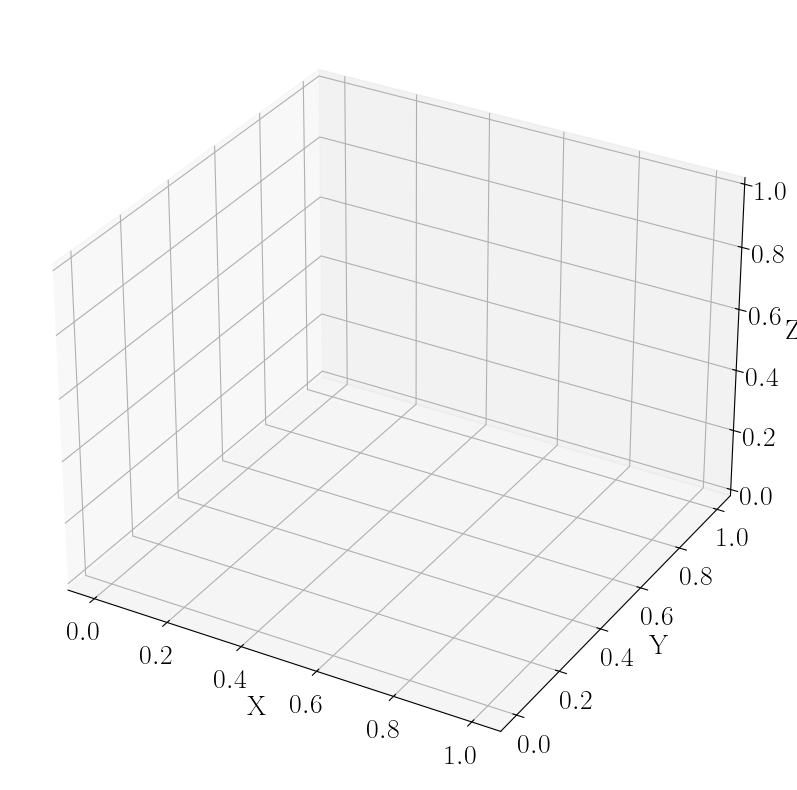

In [17]:
primary_pdg         = np.array(branch_data['primary_pdg'])
pdg = 13

primary_position_x  = np.array(branch_data['primary_position_x'][primary_pdg == pdg])
primary_position_y  = np.array(branch_data['primary_position_y'][primary_pdg == pdg])
primary_position_z  = np.array(branch_data['primary_position_z'][primary_pdg == pdg])
primary_momentum_x = np.array(branch_data['primary_momentum_x'][primary_pdg == pdg])
primary_momentum_y = np.array(branch_data['primary_momentum_y'][primary_pdg == pdg])
primary_momentum_z = np.array(branch_data['primary_momentum_z'][primary_pdg == pdg])

print('position [ 0] = (',primary_position_x[0], primary_position_y[0], primary_position_z[0],')')
print('direction[ 0] = (',primary_momentum_x[0], primary_momentum_y[0], primary_momentum_z[0],')')
print('position [-1] = (',primary_position_x[-1], primary_position_y[-1], primary_position_z[-1],')')
print('direction[-1] = (',primary_momentum_x[-1], primary_momentum_y[-1], primary_momentum_z[-1],')')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(primary_position_x , primary_position_y , primary_position_z , 
          primary_momentum_x, primary_momentum_y, primary_momentum_z, 
          length=0.1, color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.show()

100%|██████████| 1/1 [00:00<00:00, 237.25it/s]
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11163/1737757703.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


pdg = 13


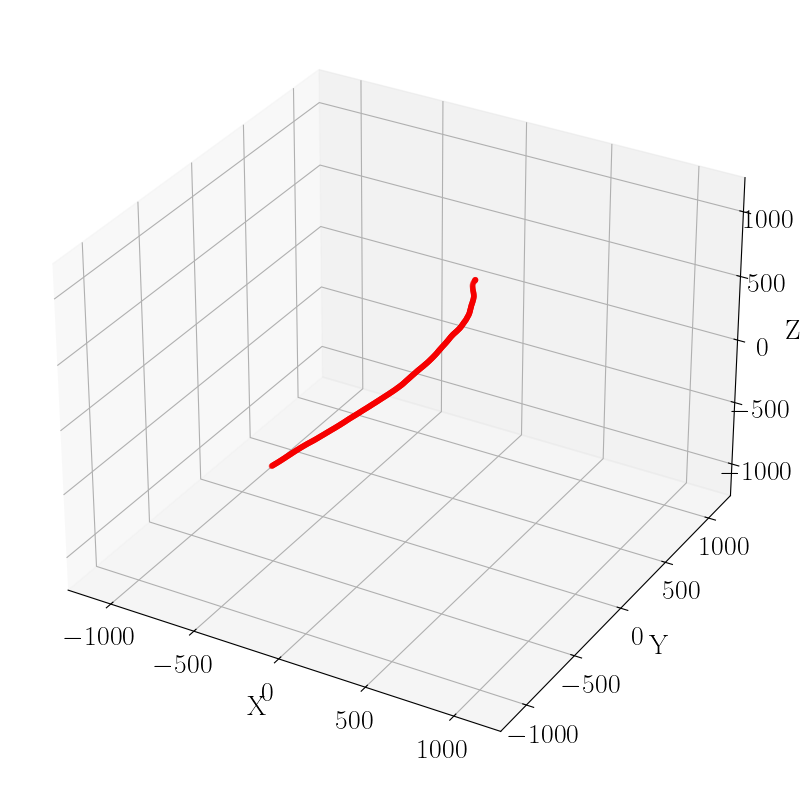

In [18]:
# %matplotlib qt
# %matplotlib inline

primary_pdg = np.array(branch_data['primary_pdg'])
# pdgs = [13, 11]
pdgs = np.unique(primary_pdg).tolist()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for pdg in tqdm.tqdm(pdgs):
    print('pdg =', pdg)
    primary_position_x  = np.array(branch_data['primary_position_x'])[primary_pdg == pdg]
    primary_position_y  = np.array(branch_data['primary_position_y'])[primary_pdg == pdg]
    primary_position_z  = np.array(branch_data['primary_position_z'])[primary_pdg == pdg]

    # photoSensor_hit_position_initial_x = np.array(branch_data['photoSensor_hits_position_initial_x'])[primary_pdg == pdg]
    # photoSensor_hit_position_initial_y = np.array(branch_data['photoSensor_hits_position_initial_y'])[primary_pdg == pdg]
    # photoSensor_hit_position_initial_z = np.array(branch_data['photoSensor_hits_position_initial_z'])[primary_pdg == pdg]

    ax.scatter(primary_position_x, 
               primary_position_y, 
               primary_position_z, 
               color='red', marker='o', s=10, alpha=0.1)
    # ax.scatter(photoSensor_hit_position_initial_x, 
    #            photoSensor_hit_position_initial_y, 
    #            photoSensor_hit_position_initial_z,
    #            color='blue', marker='x', s=10)
ax.set_xlim(-DETECTOR_SIZE_X_MM/2, DETECTOR_SIZE_X_MM/2)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2, DETECTOR_SIZE_Y_MM/2)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2, DETECTOR_SIZE_Z_MM/2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.show()

In [19]:
# Extract the data for photon_process and photon_volume
photon_process = branch_data['photon_process']
photon_volume = branch_data['photon_volume']

# Make a list of the unique photon_process and photon_volume values
unique_photon_process = np.unique(photon_process)
unique_photon_volume = np.unique(photon_volume)

# Make a dictionary to store the number of photons in each process and volume
photon_process_count = {}
photon_volume_count = {}

# # Loop over the unique photon_process values
# for process in tqdm.tqdm(unique_photon_process):
#     # Get the indices for the current process
#     indices = np.where(photon_process == process)
#     # Store the number of photons in the current process
#     photon_process_count[process] = len(indices[0])

for process in tqdm.tqdm(photon_process):
    if process in photon_process_count:
        photon_process_count[process] += 1
    else:
        photon_process_count[process] = 1

# # Loop over the unique photon_volume values
# for volume in tqdm.tqdm(unique_photon_volume):
#     # Get the indices for the current volume
#     indices = np.where(photon_volume == volume)
#     # Store the number of photons in the current volume
#     photon_volume_count[volume] = len(indices[0])

for volume in tqdm.tqdm(photon_volume):
    if volume in photon_volume_count:
        photon_volume_count[volume] += 1
    else:
        photon_volume_count[volume] = 1

# Print the photon_process_count and photon_volume_count dictionaries
print(photon_process_count)
print(photon_volume_count)

# Combine individualy named volumes into more general volumes
photon_volume_general_count = {}
for volume in tqdm.tqdm(photon_volume_count):
    if 'lensSystem_lens' in volume:
        photon_volume_general_count['lensSystem_lens'] = photon_volume_general_count.get('lensSystem_lens', 0) + photon_volume_count[volume]
    elif 'photoSensor_surface' in volume:
        photon_volume_general_count['photoSensor_surface'] = photon_volume_general_count.get('photoSensor_surface', 0) + photon_volume_count[volume]
    elif 'photoSensor_body' in volume:
        photon_volume_general_count['phototSensor_body'] = photon_volume_general_count.get('phototSensor_body', 0) + photon_volume_count[volume]
    # elif 'calorimeter_horizontal' in volume:
    #     photon_volume_general_count['calorimeter_horizontal'] = photon_volume_general_count.get('calorimeter_horizontal', 0) + photon_volume_count[volume]
    # elif 'calorimeter_vertical' in volume:
    #     photon_volume_general_count['calorimeter_vertical'] = photon_volume_general_count.get('calorimeter_vertical', 0) + photon_volume_count[volume]
    # elif 'calorimeter_middle' in volume:
    #     photon_volume_general_count['calorimeter_middle'] = photon_volume_general_count.get('calorimeter_middle', 0) + photon_volume_count[volume]
    elif 'calorimeter' in volume:
        photon_volume_general_count['calorimeter'] = photon_volume_general_count.get('calorimeter', 0) + photon_volume_count[volume]
    else:
        photon_volume_general_count[volume] = photon_volume_general_count.get(volume, 0) + photon_volume_count[volume]

# Print the photon_volume_general_count dictionary
print(photon_volume_general_count)

100%|██████████| 12507364/12507364 [01:23<00:00, 150563.57it/s]


{'phot': 254, 'compt': 126, 'Rayl': 25, 'conv': 5, 'Transportation': 12432833, 'OpAbsorption': 74121}
{'detector_medium_medium_0': 3729522, '/DSPD_+z_320.000000_640.000000_1184.704220_78_lensSystem_lens_1_preTrim': 9899, '/calorimeter_horizontal_+z_320.000000_720.000000_1445.000000_83_G4Box': 4514, '/DSPD_-y_-480.000000_-1184.704220_480.000000_154_lensSystem_lens_1_preTrim': 2782, '/DSPD_-y_-480.000000_-1184.704220_480.000000_154_lensSystem_lens_0_lens': 677, '/calorimeter_vertical_-y_-560.000000_-1445.000000_480.000000_169_G4Box': 1068, '/DSPD_+y_-320.000000_1184.704220_320.000000_144_lensSystem_lens_1_preTrim': 5424, '/calorimeter_vertical_+y_-400.000000_1445.000000_320.000000_159_G4Box': 1593, '/DSPD_+y_-480.000000_1184.704220_320.000000_159_lensSystem_lens_0_lens': 809, '/DSPD_+z_800.000000_480.000000_1184.704220_34_lensSystem_lens_1_preTrim': 16203, '/calorimeter_vertical_+z_880.000000_480.000000_1445.000000_34_G4Box': 4533, '/calorimeter_vertical_-y_400.000000_-1445.000000_800.00

100%|██████████| 9563/9563 [00:00<00:00, 3032902.02it/s]


{'detector_medium_medium_0': 3729522, 'lensSystem_lens': 4626009, 'calorimeter': 3653066, 'photoSensor_surface': 224644, 'phototSensor_body': 242529, 'detector_wall': 31594}


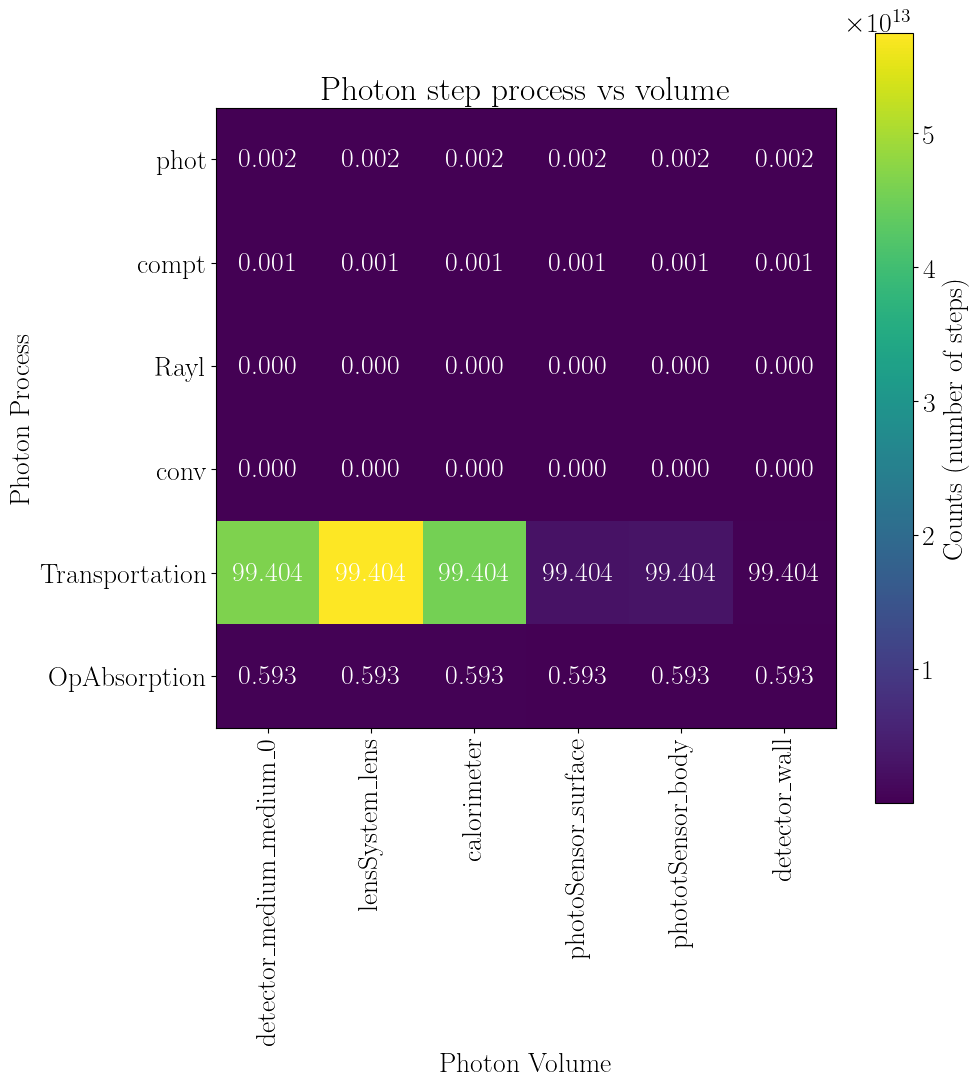

In [20]:
threshold = 0

non_zero_photon_volume = {k: v for k, v in photon_volume_general_count.items() if v >= threshold}
non_zero_photon_process = {k: v for k, v in photon_process_count.items() if v >= threshold}

photon_volume_general_count_values = list(non_zero_photon_volume.values())
photon_process_count_values = list(non_zero_photon_process.values())

convolution_matrix = np.outer(photon_process_count_values, photon_volume_general_count_values)
convolution_matrix_percentage = convolution_matrix / np.sum(convolution_matrix, axis=0) * 100

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(convolution_matrix, cmap='viridis')

excess = 1 #1e12

# Add text annotations
for i in range(len(non_zero_photon_process)):
    for j in range(len(non_zero_photon_volume)):
        text = ax.text(j, i, '{:.3f}'.format(convolution_matrix_percentage[i, j]/excess),
                       ha="center", va="center", color="w")

fig.colorbar(im, ax=ax, label='Counts (number of steps)')
ax.set_xlabel("Photon Volume")
ax.set_ylabel("Photon Process")
ax.set_title("Photon step process vs volume")
ax.set_yticks(range(len(non_zero_photon_process)))
ax.set_yticklabels(non_zero_photon_process.keys())
ax.set_xticks(range(len(non_zero_photon_volume)))
ax.set_xticklabels(non_zero_photon_volume.keys(), rotation=90)
# plt.savefig('../figures/photon_step_process_vs_volume_NEST.pdf', format='pdf', bbox_inches='tight')
plt.show()